# Predicting Flight Delays with sklearn

In this notebook, we will be using features we've prepared in PySpark to predict flight delays via regression and classification.

In [1]:
import sys, os, re
sys.path.append("lib")
import utils

import numpy as np
import sklearn
import iso8601
import datetime
print("Imports loaded...")

Imports loaded...


## Load and Inspect our JSON Training Data

In [2]:
# Load and check the size of our training data. May take a minute.
print("Original JSON file size: {:,} Bytes".format(os.path.getsize("../data/simple_flight_delay_features.jsonl")))
training_data = utils.read_json_lines_file('../data/simple_flight_delay_features.jsonl')
print("Training items: {:,}".format(len(training_data))) # 5,714,008
print("Data loaded...")

Original JSON file size: 1,676,709,758 Bytes
Training items: 5,714,008
Data loaded...


In [3]:
# Inspect a record before we alter them
print("Size of training data in RAM: {:,} Bytes".format(sys.getsizeof(training_data))) # 50MB
print(training_data[0])

Size of training data in RAM: 50,897,424 Bytes
{'DayOfWeek': 4, 'ArrDelay': 13.0, 'Dest': 'DFW', 'FlightDate': '2014-12-31T16:00:00.000-08:00', 'Carrier': 'AA', 'Distance': 569.0, 'FlightNum': '1024', 'CRSArrTime': '2015-01-01T10:10:00.000-08:00', 'CRSDepTime': '2015-01-01T07:30:00.000-08:00', 'DayOfMonth': 1, 'DayOfYear': 1, 'DepDelay': 14.0, 'Origin': 'ABQ'}


## Sample our Data

In [4]:
# We do not need to sample our data, it fits into RAM. But if you id however, this is how
training_data = np.random.choice(training_data, 1000000) # 'Sample down to 1MM examples'
print("Sampled items: {:,} Bytes".format(len(training_data)))
print("Data sampled...")

Sampled items: 1,000,000 Bytes
Data sampled...


## Vectorize the Results (y)

In [5]:
# Separate our results from the rest of the data, vectorize and size up
results = [record['ArrDelay'] for record in training_data]
results_vector = np.array(results)
print("Results vectorized size: {:,}".format(sys.getsizeof(results_vector))) # 45,712,160 bytes
print("Results vectorized...")

Results vectorized size: 8,000,096
Results vectorized...


## Prepare Training Data

In [6]:
# Remove the two delay fields and the flight date from our training data
for item in training_data:
  item.pop('ArrDelay', None)
  item.pop('FlightDate', None)
print("ArrDelay and FlightDate removed from training data...")

ArrDelay and FlightDate removed from training data...


In [7]:
# Must convert datetime strings to unix times
for item in training_data:
  if isinstance(item['CRSArrTime'], str):
    dt = iso8601.parse_date(item['CRSArrTime'])
    unix_time = int(dt.timestamp())
    item['CRSArrTime'] = unix_time
  if isinstance(item['CRSDepTime'], str):
    dt = iso8601.parse_date(item['CRSDepTime'])
    unix_time = int(dt.timestamp())
    item['CRSDepTime'] = unix_time
print("CRSArr/DepTime converted to unix time...")

CRSArr/DepTime converted to unix time...


## Vectorize Training Data with `DictVectorizer`

In [8]:
# Use DictVectorizer to convert feature dicts to vectors
from sklearn.feature_extraction import DictVectorizer

print("Sampled dimensions: [{:,}]".format(len(training_data)))
vectorizer = DictVectorizer()
training_vectors = vectorizer.fit_transform(training_data)
print("Size of DictVectorized vectors: {:,} Bytes".format(training_vectors.data.nbytes))
print("Training data vectorized...")

Sampled dimensions: [1,000,000]
Size of DictVectorized vectors: 87,539,400 Bytes
Training data vectorized...


## Prepare Experiment by Splitting Data into Train/Test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  training_vectors,
  results_vector,
  test_size=0.1,
  random_state=43
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print("Test train split performed...")

(900000, 7436) (100000, 7436)
(900000,) (100000,)
Test train split performed...


## Train our Model(s) on our Training Data

In [10]:
# Train a regressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score
print("Regressor library and metrics imported...")

Regressor library and metrics imported...


In [11]:
regressor = LinearRegression()
print("Regressor instantiated...")

Regressor instantiated...


In [12]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor
print("Swapped gradient boosting trees for linear regression!")

# Lets go back for now...
regressor = LinearRegression()
print("Swapped back to linear regression!")

Swapped gradient boosting trees for linear regression!
Swapped back to linear regression!


In [13]:
regressor.fit(X_train, y_train)
print("Regressor fitted...")

Regressor fitted...


## Predict Using the Test Data

In [14]:
predicted = regressor.predict(X_test)
print("Predictions made for X_test...")

Predictions made for X_test...


## Evaluate and Visualize Model Accuracy

In [15]:
from sklearn.metrics import median_absolute_error, r2_score

# Median absolute error is the median of all absolute differences between the target and the prediction.
# Less is better, more indicates a high error between target and prediction.
medae = median_absolute_error(y_test, predicted)
print("Median absolute error:    {:.3g}".format(medae))

# R2 score is the coefficient of determination. Ranges from 1-0, 1.0 is best, 0.0 is worst.
# Measures how well future samples are likely to be predicted.
r2 = r2_score(y_test, predicted)
print("r2 score:                 {:.3g}".format(r2))

Median absolute error:    9.68
r2 score:                 0.828


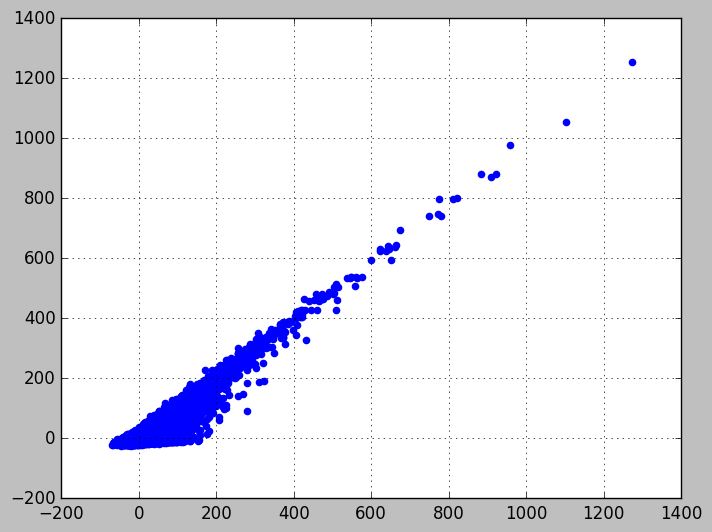

In [111]:
# Plot outputs
import matplotlib.pyplot as plt

# Cleans up the appearance
plt.rcdefaults()

plt.scatter(
  y_test,
  predicted,
  color='blue',
  linewidth=1
)
plt.grid(True)

plt.xticks()
plt.yticks()

plt.show()

## Fit and Test GradientBoostingRegressor Model

In [23]:
regressor = GradientBoostingRegressor()
print("Swapped gradient boosting trees for linear regression, yet again!")

Swapped gradient boosting trees for linear regression, yet again!


In [24]:
regressor.fit(X_train, y_train)
print("Gradient boosting regressor fitted. Note how long this takes compares to a LinearRegression...")

Gradient boosting regressor fitted...


In [27]:
dense_X_test = X_test.toarray()
print("Made X_test dense...")
predicted = regressor.predict(dense_X_test)
print("Random forest predictions made for X_test...")

Made X_test dense...
Random forest predictions made for X_test...


In [28]:
medae = median_absolute_error(y_test, predicted)
print("Gradient boosting regressor median absolute error:    {:.3g}".format(medae))

r2 = r2_score(y_test, predicted)
print("Gradient boosting regressor r2 score:                 {:.3g}".format(r2))

Gradient boosting regressor median absolute error:    6.52
Gradient boosting regressor r2 score:                 0.891


## Interrogate Model, Plot Feature Importances

In [66]:
# Print the raw importances... not super useful
importances = regressor.feature_importances_
print(importances)

[ 0.03435562  0.04026441  0.00616627 ...,  0.          0.          0.        ]


In [79]:
# Get the feature importances with their labels from DictVectorizer
feature_name_importances = list(zip(vectorizer.get_feature_names(), regressor.feature_importances_))

# Count the feature importances
feature_importance_count = len(feature_name_importances)
print("Total feature importances: {:,}\n".format(feature_importance_count))

# Sort the feature importances in descending order
sorted_feature_importances = sorted(feature_name_importances, key=lambda x: -1 * x[1])

# Print the sorted feature importances
for item in sorted_feature_importances:
    print("{0: <15}: {1}".format(item[0], item[1]))

Total feature importances: 7,436

DepDelay       : 0.4727758293334072
Distance       : 0.07362670958058513
Carrier=WN     : 0.045085719190104186
CRSDepTime     : 0.04026441310382296
CRSArrTime     : 0.03435562391965766
Carrier=DL     : 0.030114572679090217
Carrier=UA     : 0.028135127999108417
Carrier=HA     : 0.020717484844285025
Carrier=F9     : 0.019623094515773848
Carrier=NK     : 0.018349869311533956
Carrier=MQ     : 0.01594230661609825
Origin=LGA     : 0.015273967797436531
Origin=ORD     : 0.015196447977722953
Origin=EWR     : 0.015189694985508963
Origin=ATL     : 0.015019983343923031
Carrier=EV     : 0.014546977311396068
DayOfWeek      : 0.013938472456726471
Carrier=AS     : 0.013579190062831014
Dest=LAX       : 0.0128141876754016
Carrier=OO     : 0.011520247629811417
Origin=JFK     : 0.009287524379439782
Carrier=US     : 0.007408785385823342
Dest=SFO       : 0.006940895849238178
Carrier=AA     : 0.006166265576224736
Dest=ORD       : 0.005973597512626461
DayOfMonth     : 0.00563

In [80]:
# Too many! Most are 0. Print only the non-zero feature importances.
non_zero_feature_importances = [feature for feature in sorted_feature_importances if feature[1] > 0.0]
non_zero_count = len(non_zero_feature_importances)
print("Total non-zero feature importances: {}\n".format(non_zero_count))

for item in non_zero_feature_importances:
    print("{0: <15}: {1}".format(item[0], item[1]))

Total non-zero feature importances: 54

DepDelay       : 0.4727758293334072
Distance       : 0.07362670958058513
Carrier=WN     : 0.045085719190104186
CRSDepTime     : 0.04026441310382296
CRSArrTime     : 0.03435562391965766
Carrier=DL     : 0.030114572679090217
Carrier=UA     : 0.028135127999108417
Carrier=HA     : 0.020717484844285025
Carrier=F9     : 0.019623094515773848
Carrier=NK     : 0.018349869311533956
Carrier=MQ     : 0.01594230661609825
Origin=LGA     : 0.015273967797436531
Origin=ORD     : 0.015196447977722953
Origin=EWR     : 0.015189694985508963
Origin=ATL     : 0.015019983343923031
Carrier=EV     : 0.014546977311396068
DayOfWeek      : 0.013938472456726471
Carrier=AS     : 0.013579190062831014
Dest=LAX       : 0.0128141876754016
Carrier=OO     : 0.011520247629811417
Origin=JFK     : 0.009287524379439782
Carrier=US     : 0.007408785385823342
Dest=SFO       : 0.006940895849238178
Carrier=AA     : 0.006166265576224736
Dest=ORD       : 0.005973597512626461
DayOfMonth     : 0

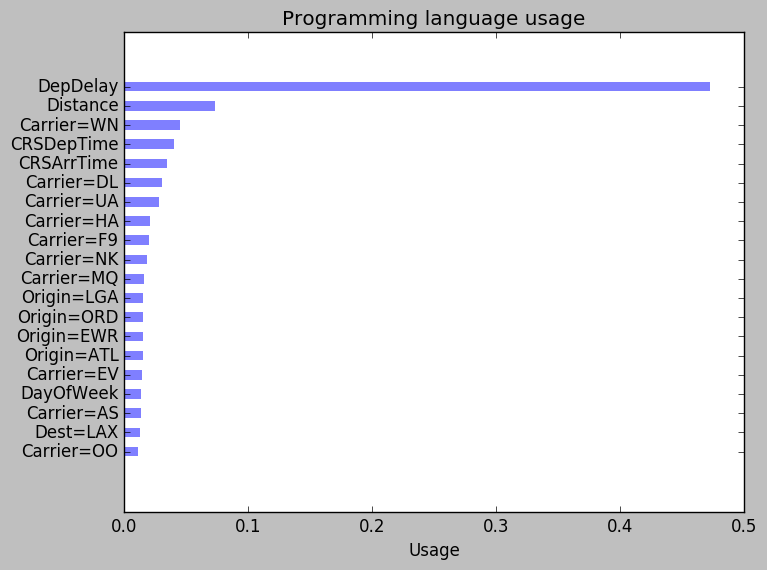

In [110]:
# Plot the top 20 feature importances
top_20_feature_importanes = non_zero_feature_importances[0:20]
top_20_feature_importanes

# Cleans up the appearance
plt.rcdefaults()
 
labels = [i[0] for i in top_20_feature_importanes]
reversed_labels = list(reversed(labels))

y_pos = [1.6 * item for item in np.arange(len(labels))]

chart_feature_importances = [i[1] for i in top_20_feature_importanes]
reversed_cfis = list(reversed(chart_feature_importances))

# See http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.barh
plt.barh(
    y_pos, 
    reversed_cfis, 
    align='center', 
    alpha=0.5,
    linewidth=0,
)
plt.yticks(y_pos, reversed_labels)
plt.xlabel('Usage')
plt.title('Programming language usage')
 
plt.show()

## Try Again: Remove Departure Delay, Make Problem Harder

In [112]:
# Remove the two delay fields and the flight date from our training data
for item in training_data:
  if 'DepDelay' in item:
      item.pop('DepDelay', None)
print("DepDelay removed from training data...")

DepDelay removed from training data...


In [113]:
# Refit data to DictVectorizer
print("Original dimensions: [{:,}]".format(len(training_data)))
training_vectors = vectorizer.fit_transform(training_data)
print("Size of DictVectorized vectors: {:,} Bytes".format(training_vectors.data.nbytes))
print("Training data vectorized again...")

Original dimensions: [1,000,000]
Size of DictVectorized vectors: 80,000,000 Bytes
Training data vectorized again...


In [114]:
# Redo test/train split
X_train, X_test, y_train, y_test = train_test_split(
  training_vectors,
  results_vector,
  test_size=0.1,
  random_state=17
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print("Test train split performed again...")

(900000, 7435) (100000, 7435)
(900000,) (100000,)
Test train split performed again...


In [ ]:
# Refit regression on new training data
regressor.fit(X_train, y_train)
print("Regressor fitted again...")

In [ ]:
# Predict using the test data again
predicted = regressor.predict(X_test)
print("Predictions made for X_test again...")

In [ ]:
# Get the median absolute error again
medae = median_absolute_error(y_test, predicted)
print("Median absolute error:    {:.3g}".format(medae))

# Get the r2 score gain
r2 = r2_score(y_test, predicted)
print("r2 score:                 {:.3g}".format(r2))

In [ ]:
# Plot outputs, compare actual vs predicted values
import matplotlib.pyplot as plt

plt.scatter(
  y_test,
  predicted,
  color='blue',
  linewidth=1
)

plt.xticks(())
plt.yticks(())

plt.show()

## Interrogate Model, Plot Feature Importances